In [1]:
import sys
sys.path.append("../")

import QpixAsicArray as qparray
from QpixAsicArray import heatMap
from QpixAsic import QPByte, ProcQueue
import QpixAsic as qpasic
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(7)

## options runs
bTestCalibrate = False
bTestIdle = True
bProbeFrq = False
bMakeFifoBars = False
bTestRoute = False
bTestTimeout = False
bTestData = True
bTestPush = True

# QoL when developing pyton files
%load_ext autoreload
%autoreload 2

### Inspect ASIC state

In [2]:
# unit test this based on duration of time out?
if bTestCalibrate:
    t = 1/qpa.fNominal
    nTicks = qpa[0][0].transferTicks
    r, c = qpa._nrows, qpa._ncols
    T = nTicks * t * r * c / 2 * 40
    print(r,c)
    qparray.viewAsicState(qpa, time_end=1./3.*T)

### Test IDLE

In [3]:
# make this a unit test for testing a simple idle
bTestIdle = False
if bTestIdle:
    from QpixAsicArray import PrintTransactMap

    # small params for unit test
    rows = 2
    cols = 2
    nHits = 10
    maxTime = 1 # time to idle for

    # make nHits for each asic
    asicX = sorted([i for i in range(rows)]*cols)
    asicY = [i for i in range(cols)]*rows
    asicHits = [sorted(list(np.random.rand(nHits) * maxTime)) for i in range(rows*cols)]

    # make some 'fake' df hits to read in
    testDF = {}
    testDF["nrows"] = rows
    testDF["ncols"] = cols
    testDF["hits"] = tuple(zip(asicX, asicY, asicHits))

    testingArrays = []
    qpa = qparray.QpixAsicArray(rows, cols, tiledf=testDF, debug=0)
    qpa.Route(route="snake", timeout=15e3, transact=False)
    qpa.SetPushState(enabled=True, transact=False)
    testingArrays.append(qpa)

    qpa2 = qparray.QpixAsicArray(rows, cols, tiledf=testDF, debug=0)
    qpa2.Route(route="left", timeout=15e3, transact=False)
    qpa2.SetPushState(enabled=True, transact=False)
    testingArrays.append(qpa2)


    fig, axs = plt.subplots(len(testingArrays),3, figsize=(17.5,5*len(testingArrays)))

    for ti, tile in enumerate(testingArrays):

        # go for 10ms after max time to ensure all of the events make it to the daqNode
        tile.IdleFor(maxTime + 1) 

        transactData = PrintTransactMap(tile, silent=True)

        # # build up 2d array of transactions to store in heat maps
        localData = np.zeros((rows,cols), dtype=np.int32)
        localT = transactData["LocalT"]
        for i, j, T in localT:
            localData[i][j] = T

        remoteDataT = np.zeros((rows,cols), dtype=np.int32)
        remoteT = transactData["RemoteT"]
        for i, j, T in remoteT:
            remoteDataT[i][j] = T

        remoteDataM = np.zeros((rows,cols), dtype=np.int32)
        remoteM = transactData["RemoteMax"]
        for i, j, T in remoteM:
            remoteDataM[i][j] = T

        # max number of transactions in this data time
        maxActivity = maxTime / (1/50e6 * 1800) 

        # construct the heatmaps
        heatMap(localData, rows, cols, ax=axs[ti, 0], vmin=0, vmax=128, header="ASIC Local Hits")
        heatMap(remoteDataM, rows, cols, ax=axs[ti, 1], vmin=0, vmax=256, header="ASIC Remote MAX")
        heatMap(remoteDataT, rows, cols, ax=axs[ti, 2], vmin=0, vmax=maxActivity, header="Asic Remote Transactions")

        # look at how many calls to proc queue are made
        print(f"{ti} called proc {tile._queue.processed} times.")

        # NOTE: AsicKey deprecated!
        # for asicKey, hitData in tile._daqNode.hitData.items():
        #     print(f"Received {len(hitData)} hits from {asicKey}.")

    fig.tight_layout()
    plt.show()


### calculate calibration precision

In [4]:
# make this a unit test
if bTestCalibrate:
    qpa = qparray.QpixAsicArray(3, 3, debug=0.0, timeout=1e4, deltaT=1e-6)
    r = "Left"
    qpa.Route(r, transact=False)
    qpa.Calibrate(0.0025)
    # NOTE: warning hitData deprecated
    # print(qpa._daqNode.hitData.items())
    end, counts = 0, 0
    while True:
        hit = qpa._daqNode._localFifo.Read()
        if hit is None:
            break
        if hit.wordType != qpasic.AsicWord.EVTEND:
            counts += 1
            print(hit, counts)
        else:
            end += 1

    print(f"found daq hits: {qpa._daqNode._localFifo._dataWords}")
    print(f"event end: {end}")

    # look at how many calls to proc queue are made
    print(qpa._queue.processed)

In [5]:
# investigate why some random seeds allow you to do several calibrations and others dont, maybe it is with the asic oscillation frequency?
# if bTestCalibrate:
if False:
    row = 2
    col = 2

    GuessFreqArray = []
    PercDiffArray = {}
    Keys = []
    CalibrateThroughTimes = np.arange(1, 15) * 1e-3
    freq = {}

    for number, CalTime in enumerate(CalibrateThroughTimes):
        q = qparray.QpixAsicArray(row, col, debug = 0., deltaT = 1e-6, timeEpsilon = 2e-6)
        q.Calibrate(CalTime)

        guessFrq = {}
        for k, v in q._daqNode.regData.items():
            asic = k
            daqTicks = []
            asicTicks = []
            for daqTick, Byte in v:
                daqTicks.append(daqTick)
                asicTicks.append(Byte.data) # Byte[4] or Byte.data depending what is appended
            if len(asicTicks) < 2:
                print(f'\nno work fo da calibration time {CalTime}: ')
                for asic in q:
                    print(f'osc freq: {asic.fOsc}')
                    print(f'start time {asic._startTime}')
                    print()

            # print("asic ticks:", asicTicks)
            guessFrq[asic] = (asicTicks[-1] - asicTicks[-2]) / (daqTicks[-1] - daqTicks[-2])  * q._daqNode.fOsc
            GuessFreqArray.append(guessFrq[asic])
            # print(f'appending {guessFrq[asic]} for asic {asic}')

        for asic in q:
            key = f"({asic.row}, {asic.col})"
            if key not in Keys: Keys.append(key)
            # print(f"{key} percent diff: {(guessFrq[key] - asic.fOsc) / asic.fOsc * 100:1.2E}")
            percdiff = (guessFrq[key] - asic.fOsc) / asic.fOsc * 100
            if key not in PercDiffArray:
                PercDiffArray[key] = []
            PercDiffArray[key].append(percdiff)


In [6]:
import pylab as p

# if bTestCalibrate:
if False:
    plot = np.zeros((len(CalibrateThroughTimes)))
    for runs in range(len(CalibrateThroughTimes)):
        somethingcreative = []
        for key in Keys:
            somethingcreative.append(np.absolute(PercDiffArray[key][runs]))
        plot[runs] = sum(somethingcreative) / len(Keys);

    p.plot(CalibrateThroughTimes * 1e3, plot, linestyle='-', marker='o');
    p.xlabel('Calibration Times [ms]')
    p.ylabel('Percent errors in asic frequency calculation')
    p.title('ASIC Frequency Error Calculation')


### Probe frequencies

In [7]:
def probeFrequencies():
    ## THIS PROBLEM CAN PROBABLY SOLVED BY MESSING WITH THE TIMEOUT TIME
    CalTimes = np.arange(1, 20) * 1e-3
    WorkingFreq = np.zeros((100000, 4))
    NonWorkingFreq = np.zeros((100000, 4))
    step = 0

    for j in range(1000):
        random.seed(random.randint(0, 100000))
        for i in CalTimes:
            q = qparray.QpixAsicArray(row, col, debug = 0., deltaT = 1e-5, timeEpsilon = 2e-6, timeout=2000)
            q.Interrogate(interval=i)
            if q._alert:
                for index, asic in enumerate(q):
                    NonWorkingFreq[step, index] = asic.fOsc
            else:
                for index, asic in enumerate(q):
                    WorkingFreq[step, index] = asic.fOsc
            step+=1

    WorkingFreq = WorkingFreq[NonWorkingFreq[:,0] == 0]
    WorkingFreq = WorkingFreq[WorkingFreq[:, 0] > 0, 0:3] * 1e-6
    NonWorkingFreq = NonWorkingFreq[NonWorkingFreq[:, 0] > 0, 0:3] * 1e-6
    
    return WorkingFreq, NonWorkingFreq

In [8]:
if bProbeFrq:
    from mpl_toolkits import mplot3d

    WorkingFreq, NonWorkingFreq = probeFrequencies()

    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.set_xlim(43, 58)
    ax.set_xlabel('asic (0, 0) frequency [MHz]')
    ax.set_ylim(43, 58)
    ax.set_ylabel('asic (0, 1) frequency [MHz]')
    ax.set_zlim(43, 58)
    ax.set_zlabel('asic (1, 0) frequency [MHz]')

    ax.plot(*WorkingFreq, marker = 'o', color = 'blue', linestyle = '');
    ax.plot(*NonWorkingFreq, marker = 'o', color = 'red', linestyle = '');
    ax.legend(('working frequency combinations', 'non-working frequency combinations'));
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('red')
    plt.show()

    plt.plot(WorkingFreq[:,0], WorkingFreq[:,1], marker = 'o', color = 'blue', linestyle = '')
    plt.plot(NonWorkingFreq[:,0], NonWorkingFreq[:, 1], marker = 'o', color = 'red', linestyle = '')
    plt.xlabel('asic (0, 0) frequency [MHz]')
    plt.ylabel('asic (0, 1) frequency [MHz]')
    plt.show()

### Test Route

In [9]:
import time
def testRoute(Sizes):
    FinalSize = max(Sizes)
    LeftRunTimes = np.zeros(FinalSize)
    SnakeRunTimes = np.zeros(FinalSize)
    DynamicRunTimes = np.zeros(FinalSize)
    for route in ['left', 'snake', None]:
        start = time.time()

        moveon = False
        timeout = 15e3

        for ind, size in enumerate(Sizes):
            row = size
            col = size
            numOfAsics = row * col
            array = qparray.QpixAsicArray(row, col, deltaT=1e-5, 
                timeout=timeout)

            ## setup
            ## inject hits into asics
            times = np.arange(0, 5, 0.1)
            for asic in array:
                asic.InjectHits(times=times)
            array.Route(route=route, timeout=timeout)
            ## main
            t = 0
            int_frq = 0.5 # interrogate every second
            stop = 5.5  # 100s of data
            while t < stop:
                array.Interrogate(int_frq)
                t += int_frq

            end = time.time()
            t = end - start
            if route == 'left':
                LeftRunTimes[ind] = t
            elif route == None:
                DynamicRunTimes[ind] = t
            else:
                SnakeRunTimes[ind] = t

    return LeftRunTimes, SnakeRunTimes, DynamicRunTimes

In [10]:
if bTestRoute:
    Sizes = np.arange(1, 5)
    lrt, SnakeRunTimes, DynamicRunTimes = testRoute(Sizes)
    fig, ax = plt.subplots()
    ax.plot(Sizes, lrt, color='blue')
    ax.plot(Sizes, SnakeRunTimes, color='red')
    ax.plot(Sizes, DynamicRunTimes, color='brown')
    ax.set(ylabel='cell run time [s]', xlabel='size of the square asic tile')
    ax.legend(('Left routed run times', 'Snake routed run times', 'Dynamically routed run times'))

### Test Buffers

In [11]:
def testBuffer(sizes):
    FutileRate_Snake = np.zeros_like(sizes)
    FutileRate_Left = np.zeros_like(sizes)
    FutileRate_Dynamic = np.zeros_like(sizes)

    int_frq = 0.5
    timeout = 1.5e4
    Rates = np.arange(5, 3000, 100)

    for route in [None, 'snake', 'left']:
        for ind, size in enumerate(sizes):
            # why??
            # if route == None:
            #     size+=6
            stobit = False
            row = size
            col = size
            for rate in Rates:
            
                array = qparray.QpixAsicArray(row, col, deltaT=1e-5, 
                    timeout=timeout, hitsPerSec = 1./1.)
                array.Route(route=route, timeout = timeout)

                times = np.linspace(0, int_frq, rate)
                for asic in array:
                    asic.InjectHits(times=times)

                ## main
                array.Interrogate(int_frq)

                for asic in array:
                    key = f'({asic.row}, {asic.col})'
                    if not(asic._remoteFifo._curSize == 0):
                        print(f'{route}: {key} remote fifo had {asic._remoteFifo._curSize} events left in a {size}x{size} tile')
                        stobit = True
                    if not(asic._localFifo._curSize == 0):
                        print(f'{route}: {key} local fifo had {asic._localFifo._curSize} events left in a {size}x{size} tile')
                        stobit = True
                
                if stobit:
                    # print(f'the rate is {rate}')
                    if route == 'snake':
                        FutileRate_Snake[ind] = rate
                    if route == 'left':
                        FutileRate_Left[ind] = rate
                    if route == None:
                        # why??
                        print(f'putting {rate} in the {ind} position of Dynamic')
                        FutileRate_Dynamic[ind] = rate
                    break
                
                if rate == Rates[-1]:
                    if route == 'snake':
                        print(f'{route} routed {size}x{size} asic can take da rate')
                        FutileRate_Snake[ind] = -10
                    if route == 'left':
                        print(f'{route} routed {size}x{size} asic can take da rate')
                        FutileRate_Left[ind] = -10
                    if route == None:
                        print(f'{route} routed {size}x{size} asic can take da rate')
                        FutileRate_Dynamic[ind] = -10
                    break

    return FutileRate_Snake, FutileRate_Left, FutileRate_Dynamic

In [12]:
bTestBuffers = False
if bTestBuffers:

    sizes = [8]

    frSnake, frLeft, frDynamic = testBuffer(sizes)

    plt.plot(sizes, frSnake, color = 'red', marker='o')
    plt.plot(sizes, frLeft, color = 'blue', marker='.')
    plt.plot(sizes, frDynamic, color = 'brown', marker='*')
    plt.title(f'Maximum rate of noise at {int_frq}s interrogation and timeout={timeout:2E}')
    plt.xlabel('Size of ASIC tile in nxn')
    plt.ylabel(f'Maximum hits evenly spaced in {int_frq}s')

    plt.legend(('Snake', 'Left', 'Dynamic'))

In [13]:
def testDynamicRoute():
    stobit = False
    size = 7
    for rate in np.arange(1000, 50000, 1000):
        maxTime = 0.5
        array = qparray.QpixAsicArray(size, size, deltaT=1e-5, timeout = 1.5e4)

        print(f'injecting uniform {rate} hits within {maxTime} s.')

        for asic in array:
            times = np.linspace(0, maxTime, rate)
            asic.InjectHits(times=times)

        array.Interrogate(maxTime)

        for asic in array:
            key = f'({asic.row}, {asic.col})'
            if not(asic._remoteFifo._curSize == 0):
                print(f'{key} remote fifo had {asic._remoteFifo._curSize} events left in a {size}x{size} tile')
                print(f'the rate is {rate}')
                stobit = True
            if not(asic._localFifo._curSize == 0):
                print(f'{key} local fifo had {asic._localFifo._curSize} events left in a {size}x{size} tile')
                print(f'the rate is {rate}')
                stobit = True
        
        if stobit:
            break

In [14]:
def misc():
    Sizes = np.arange(2, 11)
    GoodTiming_Snake = np.zeros_like(Sizes)
    GoodTiming_Left = np.zeros_like(Sizes)
    GoodTiming_Dynamic = np.zeros_like(Sizes)
    int_frq = 0.5
    Timeoutes = np.arange(250, 1e7, 250)
    rate = 12000

    for route in ['snake', 'left', None]:
        for ind, size in enumerate(Sizes):
            row = size
            col = size
            for timeout in Timeoutes:   
                stobit = False
                array = qparray.QpixAsicArray(row, col, deltaT=1e-5, 
                    timeout=timeout, hitsPerSec = 1./1.)
                array.Route(route=route, timeout = timeout)

                #inject the noise in the detectors
                times = np.linspace(0, int_frq, rate)
                channels = [[1, 7, 8]] * len(times)
                for asic in array:
                    asic.InjectHits(times=times, channels=channels)

                ## main
                array.Interrogate(int_frq)
                    # if array._alert:
                        # print('timeout time is too short')

                # qparray.MakeFifoBars(array)
                for asic in array:
                    key = f'({asic.row}, {asic.col})'
                    if (asic._remoteFifo._curSize == 0):
                        # print(f'{key} remote fifo had {asic._remoteFifo._curSize} events left in a {size}x{size} tile')
                        stobit = True
                    if (asic._localFifo._curSize == 0):
                        # print(f'{key} local fifo had {asic._localFifo._curSize} events left in a {size}x{size} tile')
                        # print(f'the asics timeout is {asic._timeout}') 
                        stobit = True
                
                if stobit:
                    if route == 'snake':
                        print(f'putting {timeout} in the {ind} position of {route}')
                        GoodTiming_Snake[ind] = timeout
                    elif route == 'left':
                        print(f'putting {timeout} in the {ind} position of {route}')
                        GoodTiming_Left[ind] = timeout
                    elif route == None:
                        print(f'putting {timeout} in the {ind} position of {route}')
                        GoodTiming_Dynamic[ind] = timeout
                    break
                
                if timeout == Timeoutes[-1]:
                    if route == 'snake':
                        GoodTiming_Snake[ind] = -5
                    elif route == 'left':
                        GoodTiming_Left[ind] = -5
                    elif route == None:
                        GoodTiming_Dynamic[ind] = -5
                    break

    plt.plot(Sizes, GoodTiming_Snake, color = 'red', marker='o')
    plt.plot(Sizes, GoodTiming_Left, color = 'blue', marker='.')
    plt.plot(Sizes, GoodTiming_Dynamic, color = 'brown', marker='*')
    plt.title(f'Minimum timeout time for a {int_frq}s interrogation and rate={rate}')
    plt.xlabel('Size of ASIC tile in nxn')
    plt.ylabel(f'Min timeout time [s]')

    plt.legend(('Snake', 'Left', 'Dynamic'))

### Import array by loading json data from radiogenic

In [28]:
# reading in the json file
import codecs, json

def getDF(input_file):
    obj_text = codecs.open(input_file, 'r').read()
    return json.loads(obj_text)
    
# inFile = "tiledfALL.json"
# inFile = "tiledf05.json"
# inFile = "tiledf05_10x14.json"
# inFile = "1k_rtd_data.json"
inFile = "../../jsons/1k_rtd_data_200-210.json"
neutFile = "../../jsons/neutAna.json"
obj_text = codecs.open(inFile, 'r').read()
readDF = getDF(inFile)
neutDF = getDF(neutFile)

### examine the buffer depths for a single data file

In [26]:
if False:
    qparray.MakeFifoBars(testingArrays[0])

### Test pull architecure with different routings

In [32]:
import QpixAsicArray as qparray
import numpy as np

bTestData = True
if bTestData:
    rows = readDF["nrows"]
    cols = readDF["ncols"]

    testingArrays = []

    # make a 'snake' routed Asic tile
    rad_arrayS = qparray.QpixAsicArray(rows, cols, tiledf=neutDF, debug=0, pctSpread=.005, offset=5.1)
    rad_arrayS.Route(route="snake", transact=False)
    testingArrays.append(rad_arrayS)

    # make a 'left' routed Asic tile
    rad_arrayL = qparray.QpixAsicArray(rows, cols, tiledf=neutDF, debug=0, pctSpread=.005, offset=5.1)
    rad_arrayL.Route(route="left", transact=False)
    testingArrays.append(rad_arrayL)

    # make a 'trunk' routed Asic tile along a slow trunk
    rad_arrayT = qparray.QpixAsicArray(rows, cols, tiledf=neutDF, debug=0, pctSpread=.005, offset=5.1)
    rad_arrayT.Route(route="trunk", transact=False, pos=3)
    testingArrays.append(rad_arrayT)
    
    # make a 'trunk' routed Asic tile along a fast trunk
    rad_arrayTf = qparray.QpixAsicArray(rows, cols, tiledf=neutDF, debug=0, pctSpread=.005, offset=5.1)
    rad_arrayTf.Route(route="trunk", transact=False, pos=4)
    testingArrays.append(rad_arrayTf)
    
    # dynamic routing for reference
    # rad_arrayD = qparray.QpixAsicArray(rows, cols, tiledf=readDF, debug=0)
    # rad_arrayD.Route(route=None)
    # testingArrays.append(rad_arrayD)

    for tile in testingArrays:
        tile._InjectHits(readDF["hits"])
    
    # radiogenic data lasts until 10 seconds
    TIMESTOP = 10
    intfrq = 0.5
    intHard = 10 # hard interrogate every 20s
    int_period = np.linspace(0, TIMESTOP, int(TIMESTOP/intfrq))
    for i in range(len(int_period)+1):
        for tile in testingArrays:
            # if int(tile._timeNow)%int(TIMESTOP/10)==0:
            #     print("hard int at time: ", tile._timeNow)
            useHard = bool(int(i)%intHard==0) 
            tile.Interrogate(intfrq, hard=useHard)

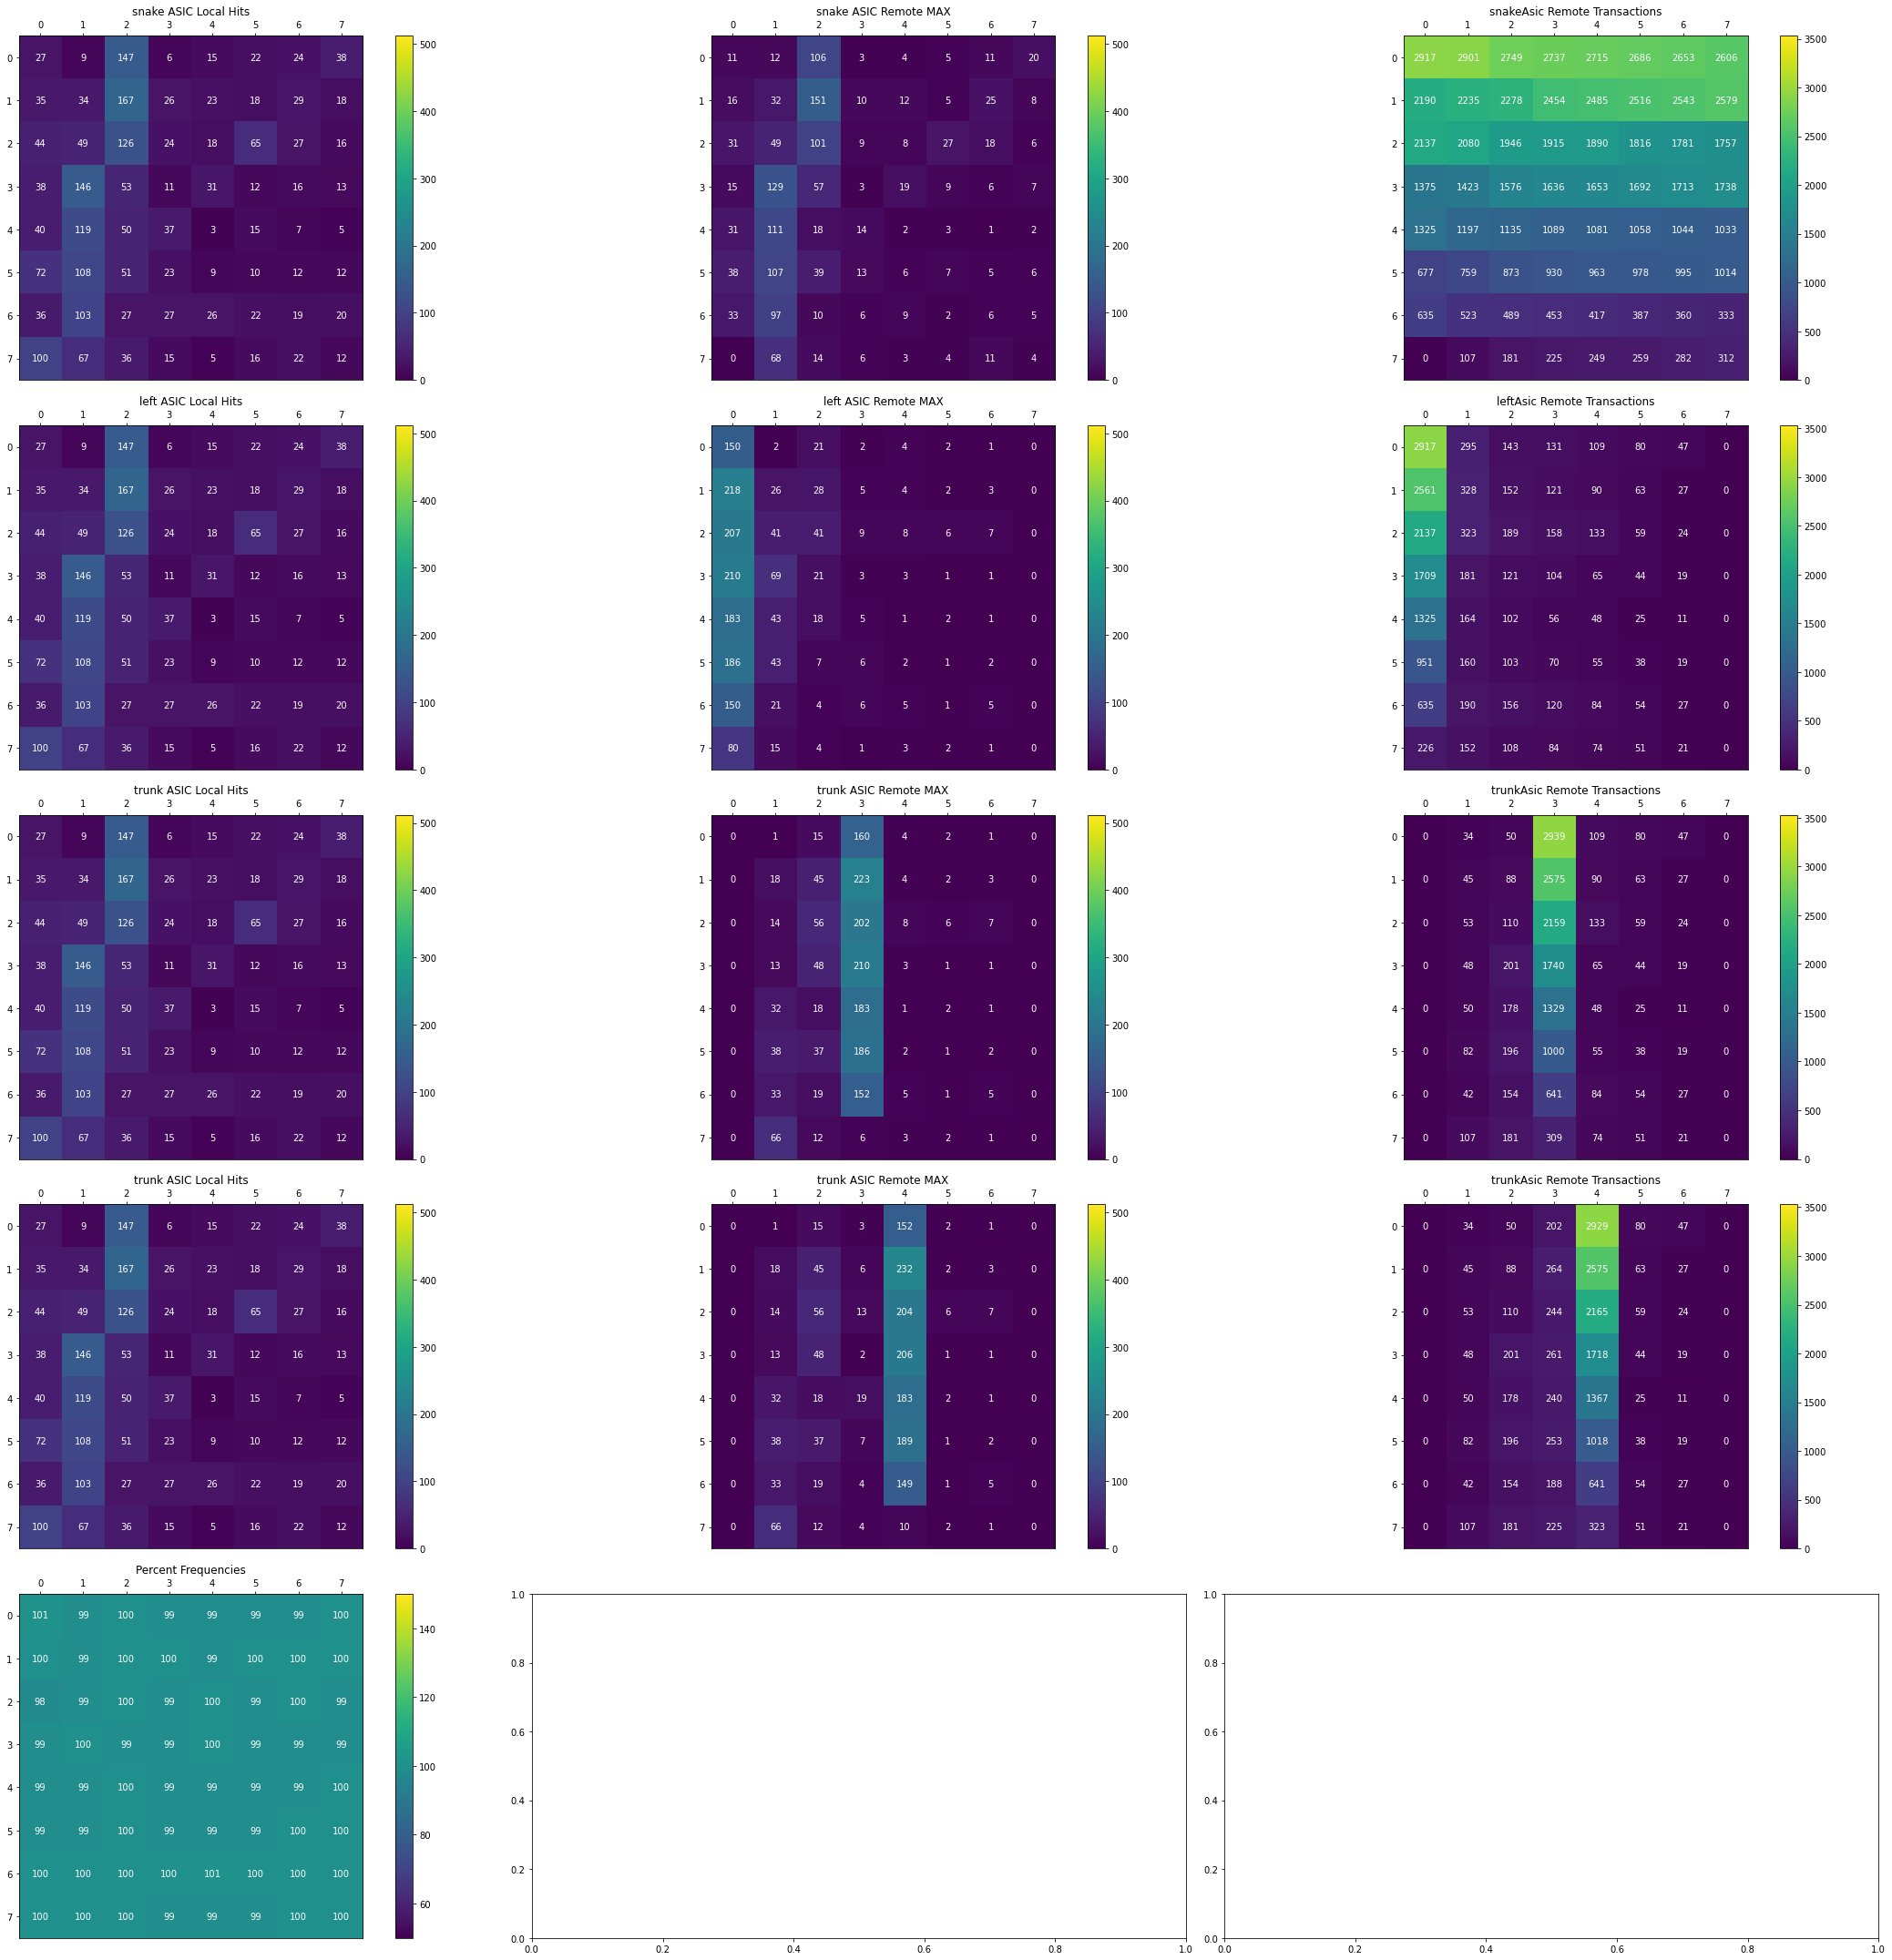

In [34]:
from QpixAsicArray import PrintTransactMap


if bTestData:
    fig, axs = plt.subplots(len(testingArrays)+1,3, figsize=(31.5,7.5*len(testingArrays)))


    for ti, tile in enumerate(testingArrays):

        transactData = PrintTransactMap(tile, silent=True)
        rows = tile._nrows
        cols = tile._ncols

        # build up 2d array of transactions to store in heat maps
        localData = np.zeros((rows,cols), dtype=np.int32)
        localT = transactData["LocalT"]
        for i, j, T in localT:
            localData[i][j] = T

        remoteDataT = np.zeros((rows,cols), dtype=np.int32)
        remoteT = transactData["RemoteT"]
        for i, j, T in remoteT:
            remoteDataT[i][j] = T

        remoteDataM = np.zeros((rows,cols), dtype=np.int32)
        remoteM = transactData["RemoteMax"]
        for i, j, T in remoteM:
            remoteDataM[i][j] = T

        # max number of transactions in this data time
        maxActivity = TIMESTOP / (1/rad_arrayS.fNominal * 1700) 

        # construct the heatmaps
        rs = f"{tile.RouteState}"
        heatMap(localData, rows, cols, ax=axs[ti, 0], vmin=0, vmax=512, header=rs+" ASIC Local Hits")
        heatMap(remoteDataM, rows, cols, ax=axs[ti, 1], vmin=0, vmax=512, header=rs+" ASIC Remote MAX")
        heatMap(remoteDataT, rows, cols, ax=axs[ti, 2], vmin=0, vmax=maxActivity/50, header=rs+"Asic Remote Transactions")

        outputFile=f"./pdfs/{rs}_asic_local.png"
        nfig, n_axis = plt.subplots(figsize=(5,5))
        heatMap(localData, rows, cols, ax=n_axis, vmin=0, vmax=512, header=rs+" ASIC Local Hits")
        nfig.savefig(outputFile)
        plt.close(nfig)

        outputFile=f"./pdfs/{rs}_asic_remote.png"
        nfig, n_axis = plt.subplots(figsize=(5,5))
        heatMap(remoteDataM, rows, cols, ax=n_axis, vmin=0, vmax=512, header=rs+" ASIC Remote MAX")
        nfig.savefig(outputFile)
        plt.close(nfig)
        
        outputFile=f"./pdfs/{rs}_asic_trans.png"
        nfig, n_axis = plt.subplots(figsize=(5,5))
        heatMap(remoteDataT, rows, cols, ax=n_axis, vmin=0, vmax=maxActivity/50, header=rs+"Asic Remote Transactions")
        nfig.savefig(outputFile)
        plt.close(nfig)    
        
    
    remoteDataFRQ = np.zeros((rows,cols), dtype=np.int32)
    arr = testingArrays[0]
    daqF = arr._daqNode.fOsc
    for i in range(arr._nrows):
        for j in range(arr._ncols):
            remoteDataFRQ[i][j] = int(arr[i][j].fOsc / daqF * 100)
    heatMap(remoteDataFRQ, rows, cols, ax=axs[4, 0], vmin=50, vmax=150, header="Percent Frequencies")
    # heatMap(remoteDataT, rows, cols, ax=axs[2, 1], vmin=0, vmax=maxActivity/100, header=rs+"Asic Remote Transactions")
    fig.tight_layout()
    plt.show()
    fig.savefig("./pdfs/pullAsics.pdf")
    
    outputFile=f"./pdfs/asic_frequency.png"
    nfig, n_axis = plt.subplots(figsize=(5,5))
    heatMap(remoteDataFRQ, rows, cols, ax=n_axis, vmin=50, vmax=150, header="Percent Frequencies")
    nfig.savefig(outputFile)
    plt.close(nfig)  

In [19]:
for ti, tile in enumerate(testingArrays):

    # build up 2d array of transactions to store in heat maps
    localData = np.zeros((rows,cols), dtype=np.int32)
    localT = transactData["LocalT"]
    for i, j, T in localT:
        localData[i][j] = T

    remoteDataT = np.zeros((rows,cols), dtype=np.int32)
    remoteT = transactData["RemoteT"]
    for i, j, T in remoteT:
        remoteDataT[i][j] = T

    remoteDataM = np.zeros((rows,cols), dtype=np.int32)
    remoteM = transactData["RemoteMax"]
    for i, j, T in remoteM:
        remoteDataM[i][j] = T

    # max number of transactions in this data time
    maxActivity = TIMESTOP / (1/rad_arrayS.fNominal * 1700) 

    # construct the heatmaps
    rs = f"{tile.RouteState}"
    heatMap(localData, rows, cols, ax=axs[ti, 0], vmin=0, vmax=512, header=rs+" ASIC Local Hits")
    heatMap(remoteDataM, rows, cols, ax=axs[ti, 1], vmin=0, vmax=512, header=rs+" ASIC Remote MAX")
    heatMap(remoteDataT, rows, cols, ax=axs[ti, 2], vmin=0, vmax=maxActivity/50, header=rs+"Asic Remote Transactions")

In [20]:
p = True
for tile in testingArrays:
    if not qparray.AnalyzeArray(tile, silent=True):
        p = False
        print("asic failure")
    print("pass with n hits:", tile.totalInjectedHits)
if p:
    print("all ASIC tiles pass.")

pass with n hits: 2391
pass with n hits: 2391
pass with n hits: 2391
pass with n hits: 2391
all ASIC tiles pass.


### Test the radiogenic data with a push architecture

In [21]:
bTestPush = False
if bTestPush:
    rows = readDF["nrows"]
    cols = readDF["ncols"]

    push_testingArrays = []
    testTimeout = 45e3

    # make a 'snake' routed Asic tile
    rad_arrayS = qparray.QpixAsicArray(rows, cols, tiledf=readDF, debug=0)
    rad_arrayS.Route(route="snake", transact=False)
    rad_arrayS.SetPushState(enabled=True, transact=False)
    push_testingArrays.append(rad_arrayS)

    # # make a 'left' routed Asic tile
    rad_arrayL = qparray.QpixAsicArray(rows, cols, tiledf=readDF, debug=0)
    rad_arrayL.Route(route="left", transact=False)
    rad_arrayL.SetPushState(enabled=True, transact=False)
    push_testingArrays.append(rad_arrayL)

    # radiogenic data lasts until 10 seconds
    TIMESTOP = 10
    intfrq = 0.5

    # listen for the entire duration
    for tile in push_testingArrays:
        tile.IdleFor(TIMESTOP + 1)


In [22]:
if bTestPush:
    fig, axs = plt.subplots(len(push_testingArrays),3, figsize=(21.5,5*len(push_testingArrays)))
    for ti, tile in enumerate(push_testingArrays):

        transactData = PrintTransactMap(tile, silent=True)

        # build up 2d array of transactions to store in heat maps
        localData = np.zeros((rows,cols), dtype=np.int32)
        localT = transactData["LocalT"]
        for i, j, T in localT:
            localData[i][j] = T

        remoteDataT = np.zeros((rows,cols), dtype=np.int32)
        remoteT = transactData["RemoteT"]
        for i, j, T in remoteT:
            remoteDataT[i][j] = T

        remoteDataM = np.zeros((rows,cols), dtype=np.int32)
        remoteM = transactData["RemoteMax"]
        for i, j, T in remoteM:
            remoteDataM[i][j] = T

        # max number of transactions in this data time
        maxActivity = TIMESTOP / (1/testingArrays[0].fNominal * 1800) 

        # construct the heatmaps
        heatMap(localData, rows, cols, ax=axs[ti, 0], vmin=0, vmax=128, header="ASIC Local Hits")
        heatMap(remoteDataM, rows, cols, ax=axs[ti, 1], vmin=0, vmax=256, header="ASIC Remote MAX")
        heatMap(remoteDataT, rows, cols, ax=axs[ti, 2], vmin=0, vmax=maxActivity, header="Asic Remote Transactions")

    fig.tight_layout()
    plt.show()


### Begin heavy lifting of analysis

In [23]:
import numpy as np
from multiprocessing import Pool
import QpixAsicArray as qparray

# set up the input data / tile information
inFile = "tiledf05_10x14.json"
import codecs, json
obj_text = codecs.open(inFile, 'r').read()
readDF = json.loads(obj_text)
nrows = readDF["nrows"]
ncols = readDF["ncols"]

# define the ranges of parameters to test
interrogation_frqs = np.linspace(0.1,1,10)
routes = ["left", "snake"]
timeouts = [15e3, 30e3, 15e4, 30e4, 15e5, 30e5]

# create the list of tiles to send to the multi-proc analysis
maxTime = 10 # seconds for how long to integrate till
tiles = [] 
int_frq = []
output_file = []
for i in interrogation_frqs:
    for r in routes:
        for t in timeouts:
            tile = qparray.QpixAsicArray(nrows, ncols, tiledf=readDF, timeout=t)
            tile.Route(r, transact=False)
            tiles.append(tile)
            int_frq.append(i)
            output_file.append(f"./output_data/timeout-{t}_route-{r}_int-{i}.json")

times = []
args = list(zip(int_frq, output_file))
print(f"testing {len(tiles)} tiles.")

FileNotFoundError: [Errno 2] No such file or directory: 'tiledf05_10x14.json'

#### Define the function for analysis, which will be sent to processes

In [ ]:
import json
def runTile(tile, int_frq, max_time, output_file):
    """
    basic function to run a tile with an integration period, over a specified time
    """
    # interrogation sequence
    int_period = np.linspace(0, max_time, int(max_time/int_frq))

    print(f"beginning interrogation of tile: {output_file}")

    for i in int_period:
        tile.Interrogate(intfrq)

    # collect the transaction map data from the tile
    transactData = PrintTransactMap(tile, silent=True)

    # save the transaction data into a output_file
    with open(output_file, "w") as of:
        json.dump(transactData, of, indent=4)

### setup of the process cores to use on runTile

In [ ]:
import os
import multiprocessing as mp
import numpy as np
def testProc(x,y):
    print(x*y)

# make a process for all available CPUs, minus 1 for ctrl thread
bMP = False
if bMP:
    ncpu = mp.cpu_count() - 1

    # ncpu2 = len(os.environ['NUMBER_OF_PROCESSORS'])
    # print("ncpu2", ncpu2)

    # create a list of all of the processes that need to run.
    procs = [mp.Process(target=runTile, args=(frq, time, outf)) for (frq, time, outf) in zip(tiles, int_frq, output_file)]
    completeProcs = 0
    runningProcs = []
    nProcs = len(procs)

    while completeProcs < nProcs:

        # fill running procs until we use all cpu threads
        while len(runningProcs) < ncpu and len(procs) > 0:
            runningProcs.append(procs.pop())

        # ensure all of the running procs have started
        for ip, p in enumerate(runningProcs):
            if p.pid is None:
                p.start()
            # take 2 seconds to attempt to join any object
            else:
                p.join(2/ncpu)

                # the process has completed, move on
                if p.exitcode is not None:
                    print(p.exitcode)
                    runningProcs.pop(ip)
                    completeProcs += 1